In [1]:
import librosa
import os
import random
import numpy as np
import csv
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/My\ Drive/End-to-end_accented
os.chdir('/content/gdrive/My Drive/End-to-end_accented')

Australia_mfcc.csv  extra_code	    Result_CNN_ERR.png	 Result_LSTM_ERR.png
Canada_mfcc.csv     GRU_model	    Result_CNN_LOSS.png  Result_LSTM_LOSS.png
CNN_model	    India_mfcc.csv  Result_GRU_ERR.png	 US_mfcc.csv
England_mfcc.csv    LSTM_model	    Result_GRU_LOSS.png


In [5]:
def csv2data(Australia, Canada, England, India, US):
  Australia_data = np.loadtxt(Australia, delimiter = ",", dtype = np.int32)
  Canada_data = np.loadtxt(Canada, delimiter = ",", dtype = np.int32)
  England_data = np.loadtxt(England, delimiter = ",", dtype = np.int32)
  India_data = np.loadtxt(India, delimiter = ",", dtype = np.int32)
  US_data = np.loadtxt(US, delimiter = ",", dtype = np.int32)

  Australia_num=1220000
  Canada_num=1280000
  England_num=1150000
  India_num=1225000
  US_num=1215000

  num=1150000

  train_num=num-(num//5)*2 #690000
  val_num=num//5 #230000
  test_num=num//5 #230000

  Australia_train = Australia_data[:train_num,:-1] #732000
  Australia_val = Australia_data[train_num:train_num+val_num,:-1]
  Australia_test = Australia_data[train_num+val_num:train_num+val_num+test_num,:-1]

  Canada_train = Canada_data[:train_num,:-1] #768000
  Canada_val = Canada_data[train_num:train_num+val_num,:-1]
  Canada_test = Canada_data[train_num+val_num:train_num+val_num+test_num,:-1]

  England_train = England_data[:train_num,:-1] #690000
  England_val = England_data[train_num:train_num+val_num,:-1]
  England_test = England_data[train_num+val_num:train_num+val_num+test_num,:-1]

  India_train = India_data[:train_num,:-1] #735000
  India_val = India_data[train_num:train_num+val_num,:-1]
  India_test = India_data[train_num+val_num:train_num+val_num+test_num,:-1]

  US_train = US_data[:train_num,:-1] #729000
  US_val = US_data[train_num:train_num+val_num,:-1]
  US_test = US_data[train_num+val_num:train_num+val_num+test_num,:-1]

  train_data = np.concatenate((Australia_train,Canada_train,England_train,India_train,US_train),axis=0)
  val_data = np.concatenate((Australia_val,Canada_val,England_val,India_val,US_val),axis=0)
  test_data = np.concatenate((Australia_test,Canada_test,England_test,India_test,US_test),axis=0)

  return train_data, val_data, test_data

In [6]:
def csv2label(Australia, Canada, England, India, US):
  Australia_data = np.loadtxt(Australia, delimiter = ",", dtype = np.int32)
  Canada_data = np.loadtxt(Canada, delimiter = ",", dtype = np.int32)
  England_data = np.loadtxt(England, delimiter = ",", dtype = np.int32)
  India_data = np.loadtxt(India, delimiter = ",", dtype = np.int32)
  US_data = np.loadtxt(US, delimiter = ",", dtype = np.int32)

  Australia_num=1220000
  Canada_num=1280000
  England_num=1150000
  India_num=1225000
  US_num=1215000

  num=1150000

  train_num=num-(num//5)*2 #690000
  val_num=num//5 #230000
  test_num=num//5 #230000

  divider=230
  
  Australia_train = Australia_data[:train_num//divider,-1] #1830
  Australia_val = Australia_data[train_num:train_num+val_num//divider,-1] #610
  Australia_test = Australia_data[train_num+val_num:train_num+val_num+test_num//divider,-1] #610
  
  Canada_train = Canada_data[:train_num//divider,-1] #1920
  Canada_val = Canada_data[train_num:train_num+val_num//divider,-1] #640
  Canada_test = Canada_data[train_num+val_num:train_num+val_num+test_num//divider,-1] #640

  England_train = England_data[:train_num//divider,-1] #1725
  England_val = England_data[train_num:train_num+val_num//divider,-1] #575
  England_test = England_data[train_num+val_num:train_num+val_num+test_num//divider,-1] #575

  India_train = India_data[:train_num//divider,-1] #1837
  India_val = India_data[train_num:train_num+val_num//divider,-1] #612
  India_test = India_data[train_num+val_num:train_num+val_num+test_num//divider,-1] #612

  US_train = US_data[:train_num//divider,-1] #1822
  US_val = US_data[train_num:train_num+val_num//divider,-1] #607
  US_test = US_data[train_num+val_num:train_num+val_num+test_num//divider,-1] #607

  train_label = np.concatenate((Australia_train,Canada_train,England_train,India_train,US_train),axis=0)
  val_label = np.concatenate((Australia_val,Canada_val,England_val,India_val,US_val),axis=0)
  test_label = np.concatenate((Australia_test,Canada_test,England_test,India_test,US_test),axis=0)

  return train_label, val_label, test_label

In [7]:
class Accent_dataset(Dataset): 
  def __init__(self, csv2data,csv2label):

    self.x_data=csv2data[:,:]
    self.y_data=csv2label[:]

    self.x_data = self.x_data.reshape(-1,230, 13)
    self.y_data = self.y_data.reshape(-1)

    self.x_data = torch.cuda.FloatTensor(self.x_data)
    self.y_data = torch.cuda.LongTensor(self.y_data)

    print("=== Dataset Download Complete !!")
    print("X shape:",self.x_data.shape)
    print("Y shape:",self.y_data.shape)

    self.len = len(self.x_data)

  def __getitem__(self, index): 
    return self.x_data[index], self.y_data[index] 

  def __len__(self): 
    return self.len

In [8]:
#parameters

num_epochs=150
learning_rate=0.0001
batch_size=256

In [9]:
train, val, test = csv2data('Australia_mfcc.csv','Canada_mfcc.csv','England_mfcc.csv','India_mfcc.csv','US_mfcc.csv')
train_label, val_label, test_label = csv2label('Australia_mfcc.csv','Canada_mfcc.csv','England_mfcc.csv','India_mfcc.csv','US_mfcc.csv')

train_dataset = Accent_dataset(train,train_label)
val_dataset = Accent_dataset(val,val_label)  
test_dataset = Accent_dataset(test,test_label)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

=== Dataset Download Complete !!
X shape: torch.Size([15000, 230, 13])
Y shape: torch.Size([15000])
=== Dataset Download Complete !!
X shape: torch.Size([5000, 230, 13])
Y shape: torch.Size([5000])
=== Dataset Download Complete !!
X shape: torch.Size([5000, 230, 13])
Y shape: torch.Size([5000])


In [10]:
#device setting

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print(device)

cuda


In [11]:
#lstm model

class LSTM_model(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers,batch_first=True):
        super(LSTM_model,self).__init__()

        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.num_layers=num_layers

        self.lstm=nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size,num_layers=self.num_layers,batch_first=True) #batch, seq_len, feature

        # Readout layer
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self,x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Decode the hidden state of the last time step
        out = self.fc(out[:,-1])

        return out

lstm_model=LSTM_model(13,150,5,2).to(device)
print(lstm_model)

LSTM_model(
  (lstm): LSTM(13, 150, num_layers=2, batch_first=True)
  (fc): Linear(in_features=150, out_features=5, bias=True)
)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
#scheduler= StepLR(optimizer,step_size=30, gamma=0.1)

Training start
Epoch:    0/150 | Train loss: 0.015431
Epoch:    0/150 | Validation loss: 1.553149
[Validation set] ERR: 0.685600 | ACC: 0.314400 (1572 / 5000)

Epoch:   10/150 | Train loss: 0.010907
Epoch:   10/150 | Validation loss: 1.082454
[Validation set] ERR: 0.489600 | ACC: 0.510400 (2552 / 5000)

Epoch:   20/150 | Train loss: 0.008286
Epoch:   20/150 | Validation loss: 0.992449
[Validation set] ERR: 0.482800 | ACC: 0.517200 (2586 / 5000)

Epoch:   30/150 | Train loss: 0.009246
Epoch:   30/150 | Validation loss: 0.953386
[Validation set] ERR: 0.458400 | ACC: 0.541600 (2708 / 5000)

Epoch:   40/150 | Train loss: 0.009004
Epoch:   40/150 | Validation loss: 0.986265
[Validation set] ERR: 0.473800 | ACC: 0.526200 (2631 / 5000)

Epoch:   50/150 | Train loss: 0.008971
Epoch:   50/150 | Validation loss: 1.018569
[Validation set] ERR: 0.474800 | ACC: 0.525200 (2626 / 5000)

Epoch:   60/150 | Train loss: 0.013822
Epoch:   60/150 | Validation loss: 1.426830
[Validation set] ERR: 0.633600 |

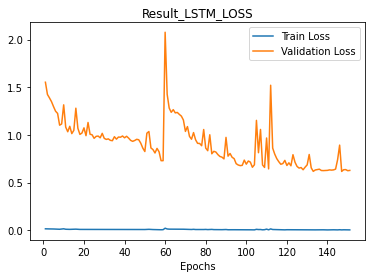

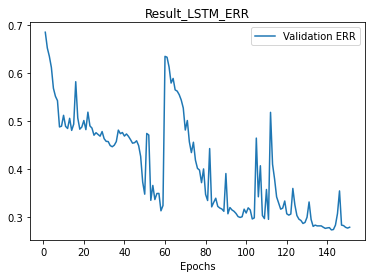

<Figure size 432x288 with 0 Axes>

In [13]:
print("Training start")

train_loss_list=[]
val_loss_list=[]

x_step=[]
y_err=[]

for epoch in range(num_epochs+1):
  for i, train_data in enumerate(train_loader):

    tain_loss = 0.0
    train_accent, train_label = train_data
  
    train_accent=train_accent.to(device)
    train_label=train_label.to(device)
    
    optimizer.zero_grad()

    hypothesis = lstm_model(train_accent).to(device)
    trn_loss = criterion(hypothesis, train_label)

    trn_loss.backward()
    optimizer.step()

    tain_loss+=trn_loss

    with torch.no_grad():

      val_loss=0.0
      correct = 0
      total = 0

      for j,val_data in enumerate(val_loader):
        val_accent, val_label = val_data
      
        val_accent=val_accent.to(device)
        val_label=val_label.to(device)

        prediction = lstm_model(val_accent)
        vl_loss = criterion(prediction, val_label)
  
        _, predicted = torch.max(prediction.data, 1)

        val_loss+=vl_loss*len(val_label)
        total += val_label.size(0)
        correct += (predicted == val_label).sum()
  
    correct = int(correct)
    total = int(total)

  if epoch % 10==0:
    print('Epoch: {:4d}/{} | Train loss: {:.6f}'.format(epoch, num_epochs, tain_loss / 100))
    print("Epoch: {:4d}/{} | Validation loss: {:.6f}".format(epoch, num_epochs, val_loss / total))
    print('[Validation set] ERR: %f | ACC: %f (%d / %d)' % (1 - (correct / total), correct / total, correct, total))
    print()
        
  train_loss_list.append(tain_loss/100)
  val_loss_list.append(val_loss/total)
  train_loss = 0.0

  x_step.append(epoch+1)
  y_err.append(1 - (correct / total))

plt.plot(x_step, train_loss_list, label = "Train Loss")
plt.plot(x_step, val_loss_list, label = "Validation Loss")
plt.xlabel('Epochs')
plt.title('Result_LSTM_LOSS')
plt.legend()
plt.savefig('Result_LSTM_LOSS.png')
plt.show()
plt.clf()

plt.plot(x_step, y_err, label = "Validation ERR")
plt.xlabel('Epochs')
plt.title('Result_LSTM_ERR')
plt.legend()
plt.savefig('Result_LSTM_ERR.png')
plt.show()
plt.clf()

In [14]:
print("Test start")

test_correct = 0
test_total = 0

with torch.no_grad():
    for k,test_data in enumerate(test_loader):
        test_accent, test_label = test_data

        test_accent=test_accent.to(device)
        test_label=test_label.to(device)

        test_prediction = lstm_model(test_accent)

        _, test_predicted = torch.max(test_prediction.data, 1)

        test_total += test_label.size(0)
        test_correct += (test_predicted == test_label).sum()

        test_correct = int(test_correct)
        test_total = int(test_total)

print('Accuracy of the model on the testset: %d %%' % (100 * test_correct / test_total))

Test start
Accuracy of the model on the testset: 66 %
